In [108]:
import GEOparse
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
import os

import sys
sys.path.append('../')
from utils import genbank_to_gene_symbol

# GSE83452

This notebook provides a brief exploration of the [GSE83452 dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE83452). Our goal is to extract (1) gene expression intensity values, (2) the condition of each patient, and (3) a symbol for each gene in the dataset.

We start by loading the dataset with GEOparse and creating a cycling iterator to go through all GEO samples.

In [2]:
gse = GEOparse.get_GEO(geo="GSE83452", destdir='../data', silent=True)
gsm_cycler = itertools.cycle(gse.gsms.items())

Here, we visualize single GEO samples, each represented by a DataFrame containing probes as rows and a `VALUE` column with the gene expression intensity values.

In [3]:
gsm_name, gsm = next(gsm_cycler)
table = gsm.table
print(table['VALUE'].describe())
table.head()

count    53617.000000
mean         4.131917
std          1.876155
min          0.648688
25%          2.672670
50%          3.930520
75%          5.274930
max         13.157700
Name: VALUE, dtype: float64


,ID_REF,VALUE
0,16650001,1.79130
1,16650003,2.78755
2,16650005,2.72220
3,16650007,1.85995
4,16650009,1.64618


Each GEO sample contains relevant metadata.

In [4]:
gsm_name, gsm = next(gsm_cycler)

for k, v in gsm.metadata.items():
    print(f'{k}: {v}')

title: ['liver biopsy 2']
geo_accession: ['GSM2203255']
status: ['Public on Jul 11 2017']
submission_date: ['Jun 16 2016']
last_update_date: ['Jul 11 2017']
type: ['RNA']
channel_count: ['1']
source_name_ch1: ['NASH liver baseline']
organism_ch1: ['Homo sapiens']
taxid_ch1: ['9606']
characteristics_ch1: ['sample name: patient 2', 'liver status: NASH', 'type of intervention: BS', 'time: baseline', 'age: 36', 'gender: male', 'scan date: 10/30/2013', 'tissue: liver biopsy']
molecule_ch1: ['total RNA']
extract_protocol_ch1: ["Trizol extraction of total RNA was performed according to the manufacturer's instructions. Clean-up RNA with DNAse treatment were performed with Rneasy microkit Qiagen according to the manufacturer's instructions"]
label_ch1: ['Biotin']
label_protocol_ch1: ['Biotinylated ssDNA were prepared according to the standard Affymetrix protocol from 100ng total RNA (GeneChip® WT PLUS Reagent Kit, Affymetrix).']
hyb_protocol: ['Following fragmentation, 5.5µg of ssDNA were hybri

We are interested in knowing the condition of each patient; hence, we extract it from the `characteristics_ch1` value. We will only keep the baseline patients (no follow-up). The dataset contains 44 control patients, 104 patients with NASH and 4 undefined. For integration with other datasets, we map these names to _control_, _NASH_, and _other_.

In [5]:
times = [next((item.split(": ")[1] for item in gsm.metadata['characteristics_ch1'] if item.startswith("time:")), None) for _, gsm in gse.gsms.items()]
keep = np.array(times) == 'baseline'

geo_accessions = [gsm.metadata['geo_accession'][0] for _, gsm in gse.gsms.items()]
stages = [next((item.split(": ")[1] for item in gsm.metadata['characteristics_ch1'] if item.startswith("liver status:")), None) for _, gsm in gse.gsms.items()]
stages = np.array(stages)[keep]
print('Original conditions: ', np.unique(stages))
mapping = {'undefined': 'other', 'no NASH': 'control', 'NASH': 'NASH'}
stages = [mapping[stage] for stage in stages]
values, counts = np.unique(stages, return_counts=True)

print('Conditions:')
for stage, count in zip(values, counts):
    print(f'- {stage}: {count}')

Original conditions:  ['NASH' 'no NASH' 'undefined']
Conditions:
- NASH: 104
- control: 44
- other: 4


Now we gather all samples in a single DataFrame.

In [6]:
data = []
for i, (gsm_name, gsm) in enumerate(gse.gsms.items()):
    if not keep[i]:
        continue
    table = gsm.table[['ID_REF', 'VALUE']]
    table.columns = ['ID_REF', gsm_name]
    data.append(table if i == 0 else table[gsm_name])
data = pd.concat(data, axis=1)
data.set_index('ID_REF', inplace=True)

data.head()

,GSM2203254,GSM2203255,GSM2203258,GSM2203259,GSM2203262,GSM2203265,GSM2203268,GSM2203269,GSM2203272,GSM2203273,...,GSM2203473,GSM2203474,GSM2203475,GSM2203476,GSM2203477,GSM2203479,GSM2203480,GSM2203481,GSM2203483,GSM2203484
ID_REF,,,,,,,,,,,,,,,,,,,,,
16650001,1.79130,1.65554,2.16053,1.97619,1.27673,1.79229,1.53117,1.70543,2.22094,1.61602,...,1.42847,1.19757,1.52731,1.07109,1.36751,1.61609,1.63795,2.02513,2.08370,1.72153
16650003,2.78755,1.81902,2.20186,3.10035,2.18813,1.92126,1.22898,2.22192,2.19172,2.34115,...,2.52917,1.68349,2.89237,2.32084,2.61395,1.93650,2.05539,2.45931,2.36854,2.54683
16650005,2.72220,2.43132,2.50152,3.03165,3.04206,2.45832,3.21054,2.10939,2.62428,2.08006,...,3.97090,2.45031,3.76014,2.31483,4.20759,4.35574,3.74464,3.53916,3.38904,3.91531
16650007,1.85995,2.98570,1.88125,2.09735,2.65538,2.74071,2.77717,2.70642,1.75788,2.40195,...,1.53167,2.75837,2.31899,1.72922,2.04184,2.86784,2.72813,1.88561,1.96488,1.94075
16650009,1.64618,1.39880,1.66951,1.45954,1.29823,1.35632,1.14080,1.25253,1.11181,1.04873,...,1.17227,1.15955,1.03668,1.21939,1.08816,1.09980,1.05967,1.32811,1.51019,2.06859


Let's plot the distribution of intensities. It seems there was some normalization done on this data. Gene expression values per sample seem to have the same scale.

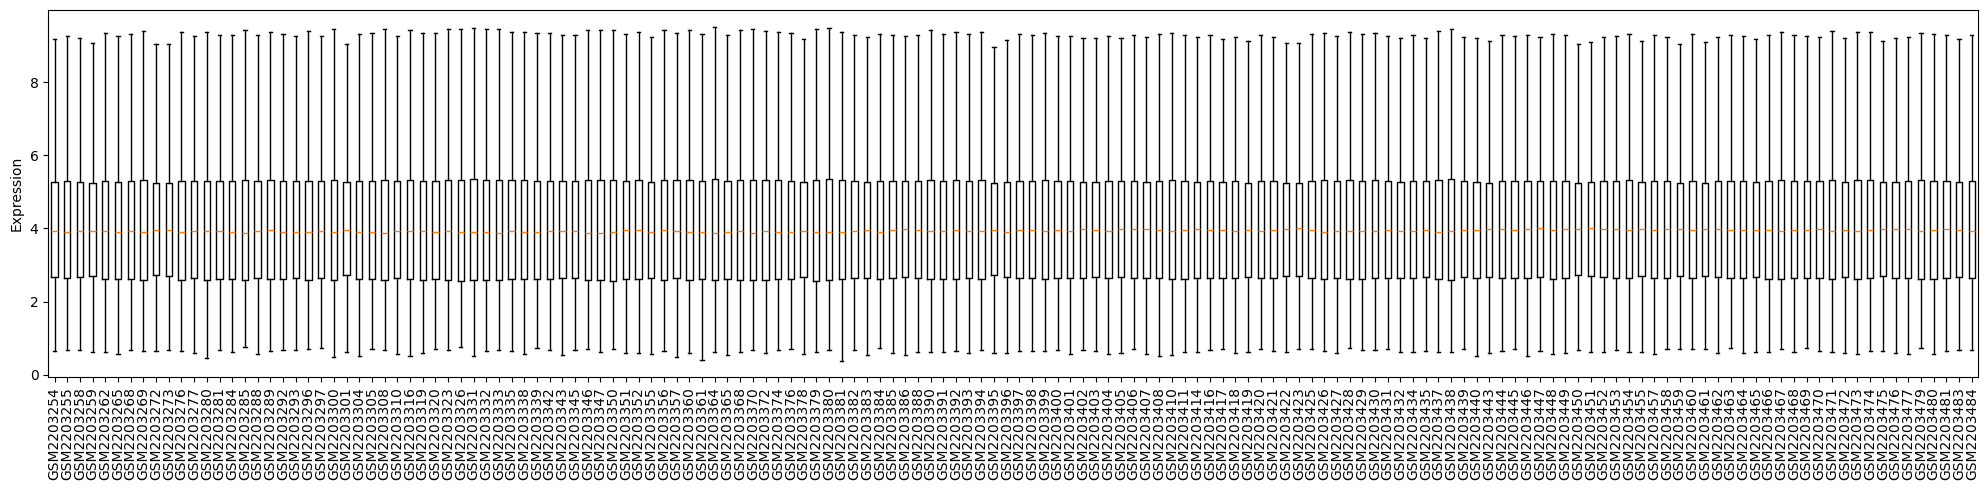

In [7]:
values = data.values.astype(float)

plt.figure(figsize=(20, 5))
plt.boxplot(values, tick_labels=data.columns, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Expression')
plt.tight_layout()
plt.show()

Finally, we look at the platform data to search for gene symbols. Our GSE object (naturally) has one single platform.

In [8]:
gse.gpls.items()

dict_items([('GPL16686', <d: GPL16686>)])

The platform metadata contains relevant information, like the microarray's name, GEO accession ID, and number of probes. The table data contains information about each probe.

In [9]:
gpl = list(gse.gpls.values())[0]

print('Title: ', gpl.metadata['title'][0])
print('GEO Accession: ', gpl.metadata['geo_accession'][0])
print('Number of probes: ', gpl.metadata['data_row_count'][0])

gpl_table = gpl.table
gpl_table.head(3)

Title:  [HuGene-2_0-st] Affymetrix Human Gene 2.0 ST Array [transcript (gene) version]
GEO Accession:  GPL16686
Number of probes:  53981


,ID,RANGE_STRAND,RANGE_START,RANGE_END,total_probes,GB_ACC,SPOT_ID,RANGE_GB
0,16657436,+,12190.0,13639.0,25.0,NR_046018,chr1:12190-13639,NC_000001.10
1,16657440,+,29554.0,31109.0,28.0,NaN,chr1:29554-31109,NC_000001.10
2,16657445,+,69091.0,70008.0,8.0,NaN,chr1:69091-70008,NC_000001.10


Here, we are interested in gene symbols. Unfortunately these are not directly accessible. We will use `biopython` to convert the `GB_ACC` column values to gene symbols. This may take a while, so we will apply multiprocessing and save the results locally for later use.

In [106]:
f = f"../data/GSE83452_symbols.npy" 

if os.path.exists(f):
    symbols = np.load(f)
else:
    def convert(task):
        index = task[0]
        value = task[1]
        if not isinstance(value, str) and np.isnan(value):
            return index, ''
        gene_symbol = genbank_to_gene_symbol(value)
        if gene_symbol is None:
            return index, ''
        return index, gene_symbol

    tasks = gpl_table['GB_ACC'].values
    tasks = list(zip(range(len(tasks)), tasks))
    pool = multiprocessing.Pool(processes=8)
    symbols = np.empty(len(tasks), dtype=object)
    for index, gene_symbol in tqdm(pool.imap_unordered(convert, tasks), total=len(tasks)):
        symbols[index] = gene_symbol
    symbols = symbols.astype(str)
    np.save(f, symbols)

100%|██████████| 53981/53981 [33:41<00:00, 26.71it/s]  


We retain 6,160 probes with 5,912 genes.

In [126]:
symbols = symbols[symbols != '']
print(f'Number of clean probes: {len(symbols)}')
print(f'Number of unique genes: {len(np.unique(symbols))}')
print(f'Example genes: {np.random.choice(np.unique(symbols), 5)}')

Number of clean probes: 6160
Number of unique genes: 5912
Example genes: ['PRAMEF14' 'PLPBP' 'MIR210HG' 'ZNF491' 'RANBP1']
